In [1]:
import os
from tensorflow.python.summary.summary_iterator import summary_iterator
import struct

2023-09-19 13:06:49.030940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 13:06:49.794782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
logdir = "logdir/f110_rl_50_0_9_/"
# Get all directories inside the logdir
all_folders = [d for d in os.listdir(logdir) if os.path.isdir(os.path.join(logdir, d))]

In [3]:
# Function to extract target_policy from folder name
def get_target_policy(folder_name):
    for part in folder_name.split(","):
        key, value = part.split("=")
        if key == "target_policy":
            return value
    return None


In [4]:
def get_dict(tag="train/pred returns"):
    # Dictionary to store returns
    all_returns = {}

    for folder in all_folders:
        dir_path = os.path.join(logdir, folder)
        
        # We'll assume there's only one file per directory as in your code. 
        # If there are multiple files, this will take the first file found.
        file_path = os.path.join(dir_path, os.listdir(dir_path)[0])
        
        target_policy = get_target_policy(folder)
        
        returns = []
        for e in summary_iterator(file_path):    
            for v in e.summary.value:
                if v.tag == tag:            
                    returns.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        # Append returns to the respective key in the dictionary
        if target_policy in all_returns:
            all_returns[target_policy].append(returns)
        else:
            all_returns[target_policy] = [returns]
    return all_returns


In [5]:
import numpy as np
def compute_statistics(data):
    """
    Compute mean and standard deviation for each list across the outer list.
    
    Args:
    - data (list of lists): Input data where inner lists contain numbers.

    Returns:
    - means (list): Mean of each list across the outer list.
    - std_devs (list): Standard deviation of each list across the outer list.
    """
    # Convert to numpy array for easier calculations
    np_data = np.array(data)
    
    # If the inner lists aren't of equal length, this will raise a ValueError
    means = np_data.mean(axis=0).tolist()
    std_devs = np_data.std(axis=0).tolist()
    
    return means, std_devs

In [6]:
all_returns_dr = get_dict(tag="train/pred returns")
std_fqe = get_dict(tag="std_deviation returns (fqe)")
mean_fqe = get_dict(tag="train/pred returns (fqe)")


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [7]:
def compute_means_std(policy_returns):
    computed_means = {}
    computed_std_devs = {}
    for target_policy, returns in policy_returns.items():
        means, std_devs = compute_statistics(returns)
        computed_means[target_policy] = means
        computed_std_devs[target_policy] = std_devs
    for target_policy in computed_means.keys():
        computed_means[target_policy] = np.mean(np.array(computed_means[target_policy])[len(computed_means[target_policy])//2:])
        computed_std_devs[target_policy] = np.mean(np.array(computed_std_devs[target_policy][len(computed_std_devs[target_policy])//2:]))
    return computed_means, computed_std_devs

In [8]:
all_returns_dr_means, all_returns_dr_std_devs = compute_means_std(all_returns_dr)
std_fqe_means, std_fqe_std_devs = compute_means_std(std_fqe)
mean_fqe_means, mean_fqe_std_devs = compute_means_std(mean_fqe)
print(mean_fqe_means)

{'velocity': 0.545027619600296, 'min_lida': 0.5580434620380401, 'raceline': 0.523678970336914, 'min_acti': 0.5827798068523407, 'td_progr': 0.5242257237434387, 'steering': 0.5569152891635895, 'vel_chan': 0.5769457936286926}


In [9]:
# For example usage:
for target_policy, returns in std_fqe.items():
    means, std_devs = compute_statistics(returns)
    print(f"For {target_policy}:")
    print(f"Means: {means}")
    print(f"Standard Deviations: {std_devs}")
    print("------")

For velocity:
Means: [0.0024581237230449915, 0.07626109570264816, 0.08194440603256226, 0.08417685329914093, 0.08731166273355484, 0.08911065012216568, 0.0926123559474945, 0.09503400325775146, 0.0980219691991806, 0.10059527307748795, 0.10290956497192383, 0.10483768582344055, 0.10740657895803452, 0.10958091169595718, 0.11080484837293625, 0.11263900250196457, 0.11263828724622726, 0.11454251408576965, 0.11618367582559586, 0.11755304783582687]
Standard Deviations: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
------
For min_lida:
Means: [0.0023766818922013044, 0.06867606192827225, 0.07599738985300064, 0.08442835509777069, 0.08922058343887329, 0.09430661052465439, 0.09717531502246857, 0.09870877861976624, 0.1015094667673111, 0.10548283904790878, 0.10621726512908936, 0.10914988815784454, 0.11066974699497223, 0.11206437647342682, 0.11331650614738464, 0.1160588338971138, 0.11785964667797089, 0.1192735880613327, 0.1206369623541832, 0.12152550

In [10]:
all_returns = get_dict()
print(all_returns.keys())
print(all_returns["min_acti"])


dict_keys(['velocity', 'min_lida', 'raceline', 'min_acti', 'td_progr', 'steering', 'vel_chan'])
[[0.7324164509773254, 0.7375397682189941, 0.7316747903823853, 0.7265916466712952, 0.723294198513031, 0.7203970551490784, 0.7216131687164307, 0.7179529070854187, 0.7196685671806335, 0.7187087535858154, 0.7170130014419556, 0.7212874293327332, 0.7195682525634766, 0.7198764085769653, 0.7218990921974182, 0.7227324843406677, 0.7170342803001404, 0.7194188833236694, 0.7177678942680359, 0.7156828045845032], [0.7324164509773254, 0.7375397682189941, 0.7316747903823853, 0.7265916466712952, 0.723294198513031, 0.7203970551490784, 0.7216131687164307, 0.7179529070854187, 0.7196685671806335, 0.7187087535858154, 0.7170130014419556, 0.7212874293327332, 0.7195682525634766, 0.7198764085769653, 0.7218990921974182, 0.7227324843406677, 0.7170342803001404, 0.7194188833236694, 0.7177678942680359, 0.7156828045845032]]


In [11]:
import numpy as np
import matplotlib.pyplot as plt

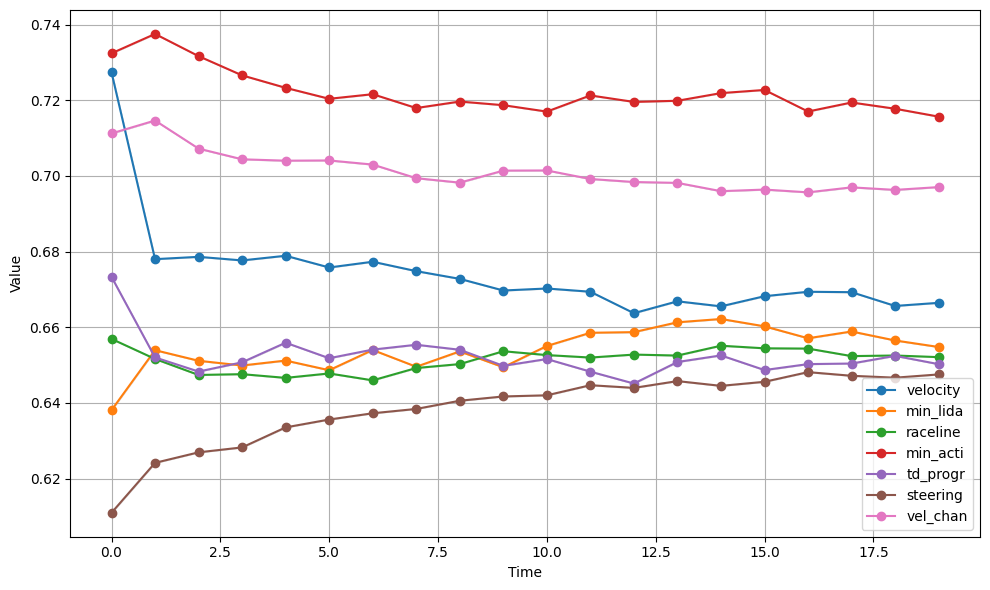

In [12]:
# The function to plot the data
def plot_data(policy, means, std_devs):
    x = list(range(len(means)))
    
    
    plt.plot(x, means, label=f"{policy}", marker='o')
    plt.fill_between(x, np.array(means) - np.array(std_devs), 
                     np.array(means) + np.array(std_devs), color='gray', alpha=0.2)
    #plt.le

# Loop through your data and plot
plt.figure(figsize=(10, 6))
computed_means = {}
computed_std_devs = {}
for target_policy, returns in all_returns.items():
    means, std_devs = compute_statistics(returns)
    computed_means[target_policy] = means
    computed_std_devs[target_policy] = std_devs
    plot_data(target_policy, means, std_devs)
    
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
print(computed_means)

{'velocity': [0.7274020910263062, 0.678006649017334, 0.6786226034164429, 0.6776729822158813, 0.6789067387580872, 0.6758053302764893, 0.677322506904602, 0.6748397350311279, 0.6727980971336365, 0.6697215437889099, 0.6702516078948975, 0.669396698474884, 0.6637260913848877, 0.666864275932312, 0.6655338406562805, 0.6682156920433044, 0.6693853139877319, 0.6692773103713989, 0.6656401753425598, 0.6664634346961975], 'min_lida': [0.6380959749221802, 0.653948187828064, 0.6511458158493042, 0.6498953104019165, 0.6511989831924438, 0.6486502289772034, 0.6539981961250305, 0.6495672464370728, 0.6536279320716858, 0.649437665939331, 0.655055046081543, 0.6585474014282227, 0.6587178111076355, 0.6613157391548157, 0.6621907949447632, 0.6602498292922974, 0.6570982336997986, 0.6588860750198364, 0.6565101146697998, 0.6547899842262268], 'raceline': [0.6569287776947021, 0.6516295671463013, 0.6473965048789978, 0.6476061344146729, 0.6466246247291565, 0.6477971076965332, 0.6459680795669556, 0.6492311954498291, 0.650

In [24]:
# caluclate the original means from the dataset
import f110_gym
import f110_orl_dataset
import gymnasium as gym
import numpy as np
# import gymnasium as gym
F110Env = gym.make('f110_with_dataset-v0',
    # only terminals are available as of tight now 
        **dict(name='f110_with_dataset-v0',
            config = dict(map="Infsaal", num_agents=1),
              render_mode="human")
    )
root = F110Env.get_dataset(zarr_path="/mnt/hdd2/fabian/f1tenth_dope/ws_ope/f1tenth_orl_dataset/data/trajectories.zarr",
                            skip_inital=50,
                            split_trajectories=50,
                            alternate_reward=True,
                            remove_short_trajectories=True
                            )
def get_change_indices(model_names):
    change_indices = []
    current_name = model_names[0]
    for idx, name in enumerate(model_names):
        if name != current_name:
            change_indices.append(idx)
            current_name = name
    return change_indices
model_names = root["infos"]["model_name"]
change_indices = get_change_indices(model_names) + [len(model_names)]
print(change_indices)


{'config': {'map': 'Infsaal', 'num_agents': 1}, 'render_mode': 'human'}
hi
===
Box([[-0.4189 -5.    ]], [[ 0.4189 20.    ]], (1, 2), float32)
low
20
Box([-30.        -30.         -6.2831855 -20.        -20.        -20.
  -0.4189      0.7         0.       ], [30.        30.         6.2831855 20.        20.        20.
  0.4189     2.         1.       ], (9,), float32)
***********
/mnt/hdd2/fabian/f1tenth_dope/ws_ope/f1tenth_orl_dataset/data/trajectories.zarr
['det' 'min_acti' 'min_lida' 'raceline' 'steering' 'td_progr' 'vel_chan'
 'velocity']
len(model_names) 352236
Indices: 352236
Using alternate reward
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
poses_theta
poses_x
poses_y
previous_action
progress
Number of timesteps: 296100
[35400, 80900, 126150, 162250, 207100, 250500, 296100]


In [25]:
def calculate_discounted_reward(rewards, done, truncated, gamma=0.99):
    # combine done and truncated
    done_or_truncated = np.logical_or(done, truncated)
    # split into segments at done or truncated
    change_indices = np.where(done_or_truncated)[0] + 1 # catch the last segment
    # ensure that we dont access out of bounds, by checking if we are at the end
    change_indices[-1] = min(change_indices[-1], len(rewards)-1)
    # calculate discounted reward for each segment
    start_idx = 0
    discounted_rewards = []
    for end_idx in change_indices:
        segment_rewards = rewards[start_idx:end_idx]
        #print(len(segment_rewards))
        discounted_reward = np.sum(segment_rewards * gamma ** np.arange(len(segment_rewards)))
        # print(f'Discounted reward: {discounted_reward}')
        discounted_rewards.append(discounted_reward)
        start_idx = end_idx
    return np.mean(discounted_rewards), np.std(discounted_rewards)

In [26]:
# for each model the number of ored dones and truncates
print("Number of ores done and truncates for each model:")
done = root['timeouts']
truncated = root['terminals']
done_or_truncated = np.logical_or(done, truncated)
start_idx = 0
# print("Discounted TD Reward")
for idx, change_idx in enumerate(change_indices):
    # count number of collisions for this model
    num_done_or_truncated = np.sum(done_or_truncated[start_idx:change_idx])
    print(f'{model_names[start_idx]}: {num_done_or_truncated}')
    start_idx = change_idx

Number of ores done and truncates for each model:
velocity: 708
raceline: 910
min_lida: 905
td_progr: 722
steering: 897
min_acti: 868
vel_chan: 912


In [36]:
# for each model calculate the mean discounted reward
start_idx = 0
print("Discounted TD Reward")
gamma = 0.85
precomputed_returns = { model_names[start_idx]: [] for start_idx in change_indices[:-1]}
precomputed_stds = { model_names[start_idx]: [] for start_idx in change_indices[:-1]}
means = []
stds = []
# model_names_.append(model_names[start_idx])
for idx, change_idx in enumerate(change_indices): # this is for each model
    # count number of collisions for this model
    try:
        mean_discounted_reward, std_discounted = calculate_discounted_reward(root['rewards'][start_idx:change_idx],
                                    root['terminals'][start_idx:change_idx],
                                    root['timeouts'][start_idx:change_idx], gamma=gamma)
        print(f'{model_names[start_idx]}: {mean_discounted_reward} +- {std_discounted} ({mean_discounted_reward* (1-gamma)} +- {std_discounted * (1-gamma)})')
        means.append(mean_discounted_reward* (1-gamma))
        stds.append(std_discounted* (1-gamma))
        precomputed_returns[model_names[start_idx]] = mean_discounted_reward* (1-gamma)
        precomputed_stds[model_names[start_idx]] = std_discounted* (1-gamma)
        start_idx = change_idx
        
    except:
        print(0)


Discounted TD Reward
velocity: 4.4098454834858405 +- 0.977978425650219 (0.6614768225228762 +- 0.14669676384753286)
raceline: 5.887534600452689 +- 0.4635927843009583 (0.8831301900679035 +- 0.06953891764514375)
min_lida: 4.219017507032196 +- 0.9269789078344677 (0.6328526260548295 +- 0.13904683617517016)
td_progr: 5.362871407886122 +- 0.7784678757002204 (0.8044307111829184 +- 0.11677018135503307)
steering: 4.402632289750004 +- 1.1210896424285501 (0.6603948434625007 +- 0.16816344636428254)
min_acti: 2.976879246542967 +- 1.408615210288952 (0.44653188698144514 +- 0.21129228154334284)
vel_chan: 3.448112367119298 +- 0.9473369018636238 (0.5172168550678948 +- 0.1421005352795436)


In [37]:
print(precomputed_returns)
print(precomputed_stds)
print(computed_means)
print(computed_std_devs)

{'raceline': 0.8831301900679035, 'min_lida': 0.6328526260548295, 'td_progr': 0.8044307111829184, 'steering': 0.6603948434625007, 'min_acti': 0.44653188698144514, 'vel_chan': 0.5172168550678948, 'velocity': 0.6614768225228762}
{'raceline': 0.06953891764514375, 'min_lida': 0.13904683617517016, 'td_progr': 0.11677018135503307, 'steering': 0.16816344636428254, 'min_acti': 0.21129228154334284, 'vel_chan': 0.1421005352795436, 'velocity': 0.14669676384753286}
{'velocity': [0.7274020910263062, 0.678006649017334, 0.6786226034164429, 0.6776729822158813, 0.6789067387580872, 0.6758053302764893, 0.677322506904602, 0.6748397350311279, 0.6727980971336365, 0.6697215437889099, 0.6702516078948975, 0.669396698474884, 0.6637260913848877, 0.666864275932312, 0.6655338406562805, 0.6682156920433044, 0.6693853139877319, 0.6692773103713989, 0.6656401753425598, 0.6664634346961975], 'min_lida': [0.6380959749221802, 0.653948187828064, 0.6511458158493042, 0.6498953104019165, 0.6511989831924438, 0.6486502289772034, 

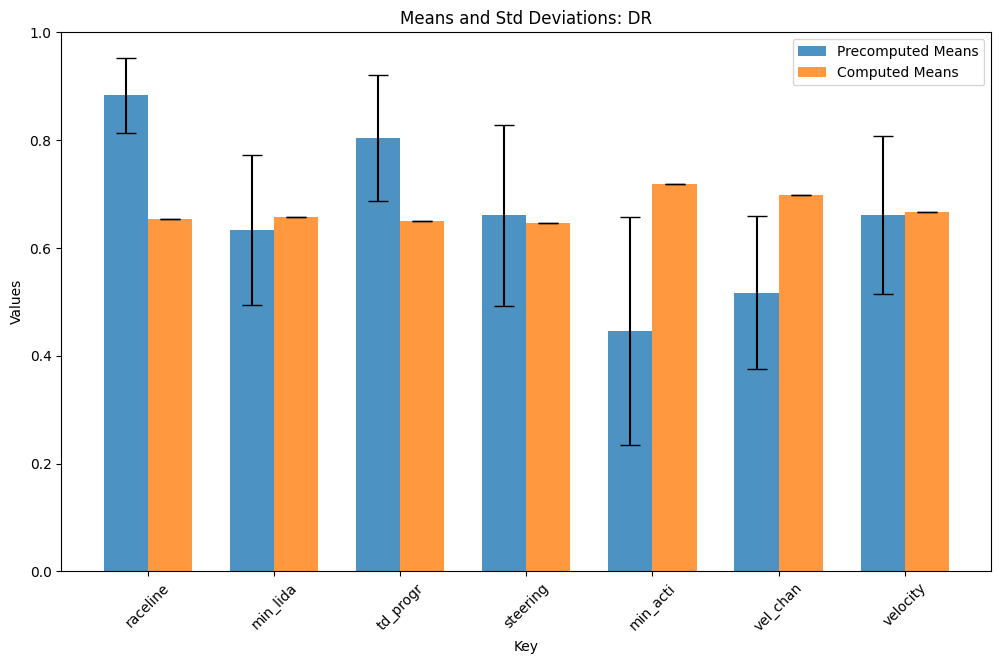

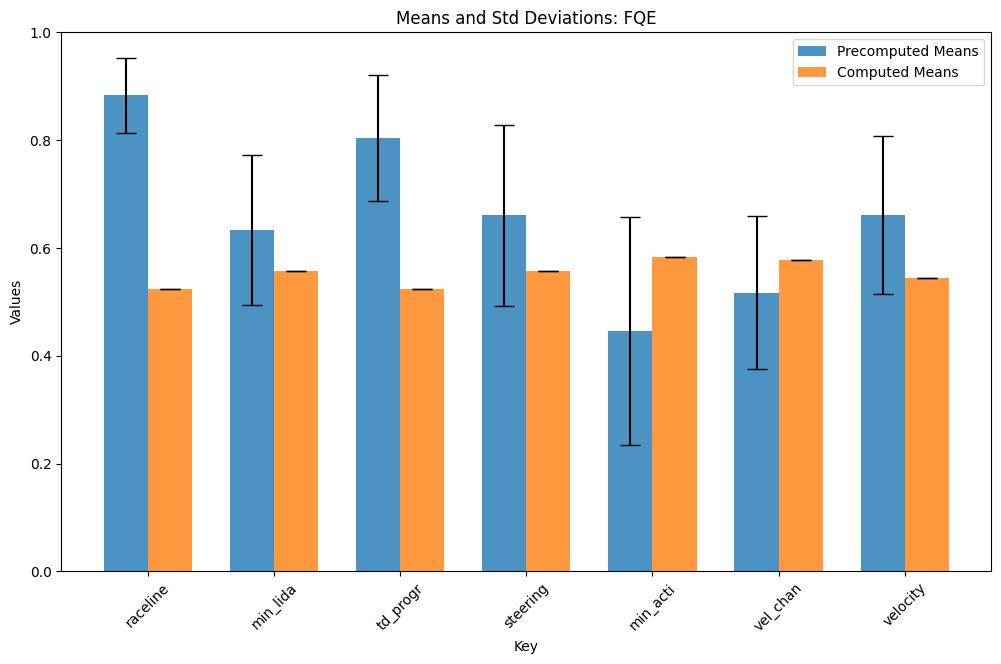

In [38]:
def plot_bar_vs(precomputed_returns, precomputed_stds, computed_means, computed_std_devs ,name = "DR"):
    # Assuming the order of precomputed_returns as the standard order
    keys = list(precomputed_returns.keys())
    precomputed_means_values = [precomputed_returns[key] for key in keys]
    precomputed_std_values = [precomputed_stds[key] for key in keys]
    computed_means_values = [computed_means[key] for key in keys]
    computed_std_values = [computed_std_devs[key] for key in keys]

    bar_width = 0.35
    index = np.arange(len(keys))

    fig, ax = plt.subplots(figsize=(12, 7))
    bar1 = ax.bar(index, precomputed_means_values, bar_width, yerr=precomputed_std_values, label='Precomputed Means', alpha=0.8, capsize=7)
    bar2 = ax.bar(index + bar_width, computed_means_values, bar_width, yerr=computed_std_values, label='Computed Means', alpha=0.8, capsize=7)

    ax.set_xlabel('Key')
    ax.set_ylabel('Values')
    ax.set_title(f"Means and Std Deviations: {name}")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(keys, rotation=45)
    ax.legend()

    plt.show()
plot_bar_vs(precomputed_returns, precomputed_stds, all_returns_dr_means, all_returns_dr_std_devs, name = "DR")
plot_bar_vs(precomputed_returns, precomputed_stds, mean_fqe_means, mean_fqe_std_devs, name = "FQE")

In [110]:
def compute_trajectory_lengths(done, truncated):
    done_or_truncated = np.logical_or(done, truncated)
    # Add an ending point to ensure the last trajectory is considered
    # done_or_truncated = np.append(done_or_truncated, [1])
    lengths = []
    count = 0
    for flag in done_or_truncated:
        if flag:
            lengths.append(count + 1)
            count = 0
        else:
            count += 1
    return lengths

Statistics for each model:
velocity:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 35400

raceline:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 45500

min_lida:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 45250

td_progr:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 36100

steering:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 44850

min_acti:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 43400

vel_chan:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 45600

7
7
7


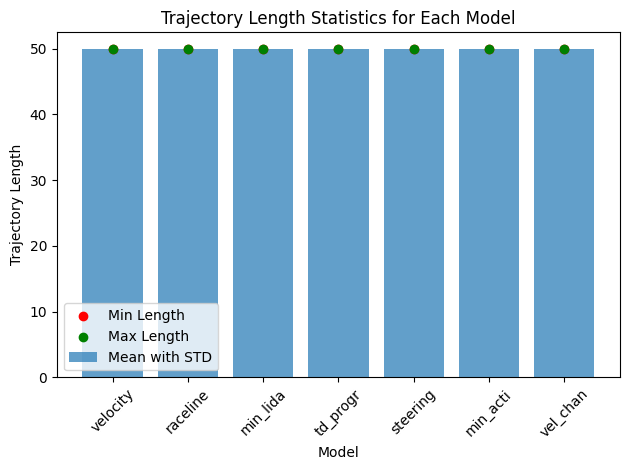

In [111]:
done = root['terminals']
truncated = root['timeouts']

start_idx = 0

# Lists for plotting
means = []
std_devs = []
mins = []
maxs = []

print("Statistics for each model:")
for idx, change_idx in enumerate(change_indices):
    current_lengths = compute_trajectory_lengths(done[start_idx:change_idx], truncated[start_idx:change_idx])

    mean_length = np.mean(current_lengths)
    std_dev = np.std(current_lengths)
    min_length = np.min(current_lengths)
    max_length = np.max(current_lengths)
    total_length = np.sum(current_lengths)
    print(f"{model_names[start_idx]}:")
    print(f"\tMean Length: {mean_length}")
    print(f"\tStandard Deviation: {std_dev}")
    print(f"\tMin Length: {min_length}")
    print(f"\tMax Length: {max_length}\n")
    print(f"\tTotal Length: {total_length}\n")
    # Add values to lists for plotting
    means.append(mean_length)
    std_devs.append(std_dev)
    mins.append(min_length)
    maxs.append(max_length)

    start_idx = change_idx

# Plotting
model_names_ = [model_names[i-1] for i in change_indices]
x = np.arange(len(np.unique(model_names)))
print(len(means))
print(len(std_devs))
print(len(x))
plt.bar(x, means, yerr=std_devs, label='Mean with STD', alpha=0.7)
plt.scatter(x, mins, color='red', label='Min Length', zorder=3)
plt.scatter(x, maxs, color='green', label='Max Length', zorder=3)

plt.xlabel('Model')
plt.ylabel('Trajectory Length')
plt.title('Trajectory Length Statistics for Each Model')
plt.xticks(x, model_names_, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Ordered Labels: ['raceline', 'min_lida', 'steering', 'td_progr', 'vel_chan', 'velocity', 'min_acti']
Ordered Means: [0.14693630769584384, 0.13479107013426772, 0.12017761282623063, 0.2941828878329745, 0.12726945278806082, 0.2836946103188693, 0.12713445333412188]
Ordered Std Devs: [0.0037664995471581113, 0.0113000199172739, 0.038079786959319344, 0.03408144002072949, 0.017277547870319026, 0.032016914931346015, 0.026519369818428628]


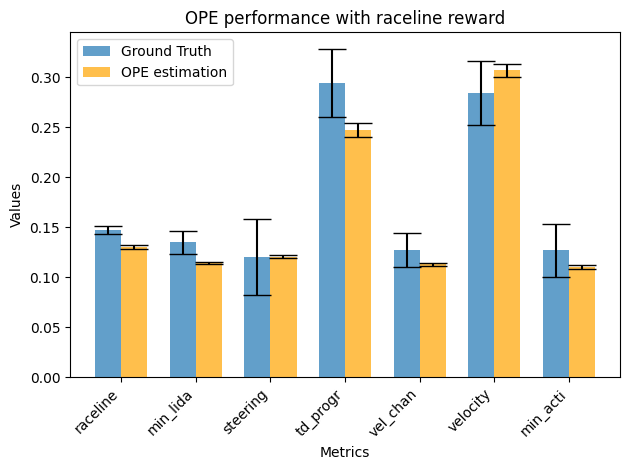

In [24]:
ordered_labels = ope_names
# Using a mapping dictionary to easily reorder the data
mapping = {label: (mean, std_dev) for label, mean, std_dev in zip(labels, original_means, original_std_devs)}

# Rearrange the means and std_devs to the new order
original_means = [mapping[label][0] for label in ordered_labels]
original_std_devs = [mapping[label][1] for label in ordered_labels]
print("Ordered Labels:", ordered_labels)
print("Ordered Means:", original_means)
print("Ordered Std Devs:", original_std_devs)

new_means = ope_means  # Replace with other means as needed
new_std_devs = ope_stds  # Replace with other std devs as needed

# Plotting
bar_width = 0.35
index = np.arange(len(labels))

# Plotting original data bars
plt.bar(index, original_means, bar_width, yerr=original_std_devs, align='center', alpha=0.7, 
        ecolor='black', capsize=10, label='Ground Truth')

# Plotting new data bars (shifted by bar_width for non-overlapping)
plt.bar(index + bar_width, new_means, bar_width, yerr=new_std_devs, align='center', alpha=0.7, 
        ecolor='black', capsize=10, label='OPE estimation', color='orange')

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('OPE performance with raceline reward')
plt.xticks(index + bar_width / 2, ordered_labels, rotation=45, ha='right')  # Positioning the x-labels in between the bars
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

Text(0, 0.5, 'OPE Estimation')

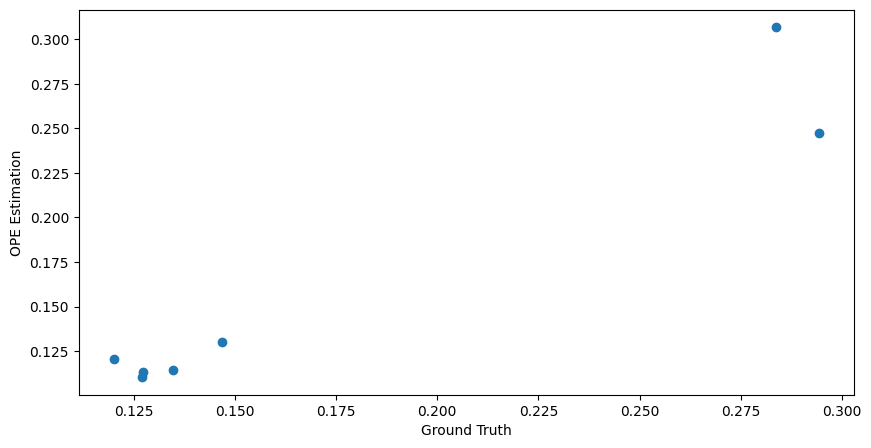

In [25]:
# plot the new means (x) vs the original means (y)
plt.figure(figsize=(10, 5))
plt.plot(original_means, new_means, 'o')
plt.xlabel("Ground Truth")
plt.ylabel("OPE Estimation")


Text(0, 0.5, 'OPE Estimation')

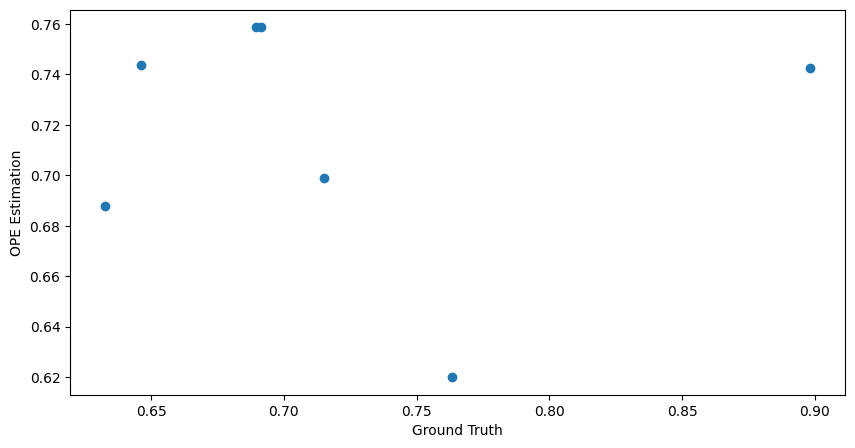

In [13]:
# plot the new means (x) vs the original means (y)
plt.figure(figsize=(10, 5))
plt.plot(original_means, new_means, 'o')
plt.xlabel("Ground Truth")
plt.ylabel("OPE Estimation")


# plot the 